# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [4]:
from types import SimpleNamespace
import numpy as np 
from scipy import optimize 
import matplotlib.pyplot as plt 


# Question 1

To answer the first question, we start out by setting the parameters to the known values. Then we proceed to define the utility function, the premium function, the expected utility function when the agent is insured and lastly the agent's optimal insurance coverage.

In [5]:
# Setting the parameters:
y = 1
p = 0.2
theta = -2
N = 100

# Defining utility:
def u(z, theta) -> float:
    """Takes two parameters and returns the utility"""
    return (z**(1 + theta)) / (1 + theta)

# Defining the premium:
def pi(p, q):
    """Takes two parameters and returns the premium policy"""
    return (p * q)

# Defining expected utility if insured
def V(q, x, y, p) -> float:
    """Takes four parameters,
    returns the expected utility of an insured agent"""
    first_term = p * u(y - x + q - pi(p, q), theta)

    second_term = (1-p) * u(y - pi(p, q), theta)
    
    return first_term + second_term

# Defining optimal insurance coverage:
def q_star(x, y, p):
    """Maximizes the expected utility if insured w.r.t q,
    Returns the agent's optimal insurance coverage"""
    obj = lambda q: -V(q, x, y, p)
    res = optimize.minimize_scalar(obj, bounds = (0, x), method = 'bounded')
    return res.x

Now we create a grid for the x's, where we want the range to be between 0.01 and 0.9, and an empty grid for the q's. Then we loop over all the xs to calculate the optimal insurance coverage, q*, for each level of monetary loss, x.

In [9]:
# ii) Grid for xs and qs
xs = np.linspace(0.01, 0.9, N)
qs = np.zeros(N)

# iii) For each x calculate q*
for i, x in enumerate(xs):
    qs[i] = q_star(xs[i], y, p)

Lastly, we plot the x's and the q's and see that the graph suggests that a higher monetary loss x entails a higher optimal coverage amount q.

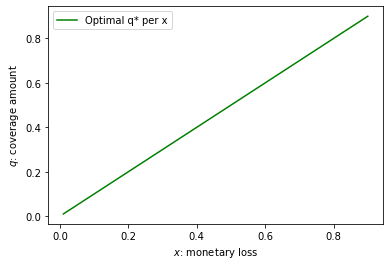

In [14]:
# iv) Plot the xs and qs
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, qs, color = 'green', label = 'Optimal q* per x')

ax.set_xlabel('$x$: monetary loss')
ax.set_ylabel('$q$: coverage amount')

ax.legend(loc='upper left');

# Question 2

The goal is to find the set of acceptable contracts from the agent's point of view.
We let the monetary loss be set to x = 0.6 and create a function for the expected value
of not having insurance. We construct a new grid of the q's and an empty one for the pi's.

In [11]:
# i) Setting the parameters:
x = 0.6

# Defining expected value if no insurance
def V_null(p:float) -> float:
    """Takes one parameter p,
    returns the expected value if not insured"""
    return p*u(y - x, theta) + (1 - p)*u(y, theta)

# Constructing a new grid of qs as well as an empty grid for the pi's 
qs_new = np.linspace(0.01, 0.6, N)
pi_new = np.zeros(N)

We make a new function for expected utility when having an insurance,
since pi is now a variable that has to be solved for. 
We create another objective function in order to optimize pi, with the constraint that all insurance contracts will yield an expected value at least as good as the case of not having an insurance.

In [12]:
#ii)
def V_pi(pi, q, x, y, p) -> float:
    """Takes four parameters,
    returns the expected utility of an insured agent"""
    first_term = p * u(y - x + q - pi, theta)

    second_term = (1-p) * u(y - pi, theta)
    
    return first_term + second_term 

# Defining optimal premium policy and optimizing pi:
def pi_star(q, x, y, p, V_null): 
    """Finds the optimal premium policy
    
    Parameters: 
        q = coverage amount
        x = monetary loss
        y = assets held by agent
        p = probability at which loss is incurred
        V_null = expected utility when not insured
    
    Returns: Optimizes the difference between expected utility if insured
    vs. if not insured w.r.t. pi = premium"""
    def obj(pi):
        return V_pi(pi, q, x, y, p) - V_null
    obj = lambda pi: V_pi(pi, q, x, y, p) - V_null
    res = optimize.root_scalar(obj, bracket=[0, q], method='brentq')
    return res.root

for i, q in enumerate(qs_new):
    pi_new[i] = pi_star(qs_new[i], x, y, p, V_null(p))

Lastly, we plot the results including both the optimal pi* per q, the premium policy found in question 1, as well as the set of acceptable contracts.

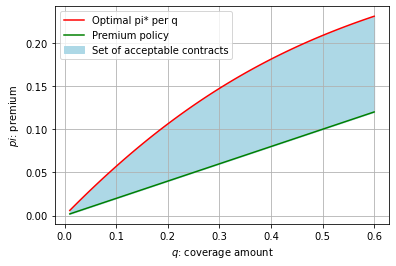

In [13]:
#iii) 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(qs_new, pi_new, color = 'red', label = 'Optimal pi* per q')
ax.plot(qs_new, p*qs_new, color = 'green', label = 'Premium policy')
ax.fill_between(qs_new, p*qs_new, pi_new, color = 'lightblue', label = 'Set of acceptable contracts')
ax.set_xlabel('$q$: coverage amount')
ax.set_ylabel('$pi$: premium')
ax.grid(True)
ax.legend(loc='upper left');

# Question 3

In this question we define a Monte Carlo function in order to find the preferred insurance policy from the agent's point of view. The loss, x, is drawn from a beta distribution. Thus, by the Law of Large Numbers, we can approximate the true integral, representing the agent's value, with a finite sample:
$$
\mathbb{E}[\mathbf{V}(\gamma, \pi)] \approx \frac{1}{N}\sum_{i=1}^{N} \mathbf{V}(\gamma_i, \pi_i) 
$$

In the first part, we set the parameters and define the new expected utility. Then we create a Monte Carlo function that, by the Law of Large Numbers, computes the agent's value.

In [18]:
# i)
# Setting the parameters:
alpha = 2
beta = 7
N = 10000


# Defining the new expected utility
def V_beta(gamma, pi): 
    """Takes two parameters: gamma and pi,
    Returns the new expected utility"""
    return u(y - (1 - gamma)*x - pi, theta)

# Defining the monte carlo function:
def monte_carlo(y, p, N, gamma, pi):
    """"Draws x from the beta distribution with N = 10000
    and uses this to return the mean of the new expected utility"""
    x = np.random.beta(alpha, beta, N)
    return np.mean(V_beta(x, pi))

We then call the monte carlo fucntion for different values of gamma and pi.
We define the two cases as policy1 and policy2.

In [20]:
# ii)
policy1 = monte_carlo(y, p, N, gamma = 0.9, pi = 0.2)
policy2 = monte_carlo(y, p, N, gamma = 0.45, pi = 0.1)

print(f'Expected utility of policy 1 is: {policy1:0.3f}')
print(f'Expected utility of policy 2 is: {policy2:0.3f}')

Expected utility of policy 1 is: -3.169
Expected utility of policy 2 is: -2.377


We can see that both policies yields negative utility. However, the insurance policy where the coverage ratio gamma is 0.45 and the premium pi is 0.1 is preferable since this will yield the smallest loss in utility for the agent.

# Question 4

In this question, we want to consider the optimal policy from the insurance company's point of view. We set the coverage ratio, gamma, equal to 0.95.
Given this parameter, the insurance company wants to maximize its profits
and we will try to find the optimal premium, pi.

In [34]:

#i)
gamma = 0.95

def pi_star2(p, x, pi, gamma): 
    def obj(pi):
        return p * (gamma * x)
    obj = lambda pi: p * (gamma * x)
    res = optimize.root(obj, [0, 0], method = 'broyden1')
    return res.root

#qs_1 = np.linspace(0.01, 0.9, N)
#pi_1 = np.zeros(N)

#for i, q in enumerate(qs_1):
#    pi_1[i] = pi_star2(p, qs_1[i], pi, gamma)


We have not been able get a value out of our last optimatization above. Help would be very much appreciated! :-)

All functions in py file

Then to get that in the IPYNB use FROM my_func IMPORT * 
(.py fil = my_func)

ADD CONCISE CONLUSION.